In [2]:
# 1. Imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

from torch_deeptype.deeptype_model import DeeptypeModel
from torch_deeptype.deeptype_trainer import DeeptypeTrainer

In [3]:
## 2. Data Loading
transform = transforms.Compose([transforms.ToTensor()])

full_train = datasets.MNIST(root='.', train=True, download=True, transform=transform)
train_set, val_set = random_split(
    full_train,
    [55000, 5000],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_set,   batch_size=128, shuffle=False)


In [4]:
## 3. Model Definition
class SimpleMLP(DeeptypeModel):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1     = nn.Linear(28*28, 128)
        self.hidden  = nn.Linear(128,  64)
        self.out     = nn.Linear(64,   10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = self.get_hidden_representations(x)
        return self.out(h)

    def get_input_layer_weights(self) -> torch.Tensor:
        return self.fc1.weight

    def get_hidden_representations(self, x: torch.Tensor) -> torch.Tensor:
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        return torch.relu(self.hidden(x))

model = SimpleMLP()


In [5]:
class EarlyStopper:
    def __init__(self, trainer, val_loader, patience, save_path):
        self.trainer    = trainer
        self.val_loader = val_loader
        self.patience   = patience
        self.best_loss  = float('inf')
        self.epochs_no_improve = 0
        self.save_path  = save_path

    def __call__(self, epoch, model, primary_loss, sparsity_loss, cluster_loss=None):
        model.eval()
        total = 0.0
        with torch.no_grad():
            for x, y in self.val_loader:
                logits = model(x)
                total += self.trainer.primary_loss_fn(logits, y).item() * x.size(0)
        val_loss = total / len(self.val_loader.dataset)
        print(f"→ [Epoch {epoch}] val_loss: {val_loss:.4f}")

        # check improvement
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.epochs_no_improve = 0
            torch.save(model.state_dict(), self.save_path)
        else:
            self.epochs_no_improve += 1
            if self.epochs_no_improve >= self.patience:
                print(f"⏹ Early stopping (patience={self.patience}) at epoch {epoch}")
                self.trainer.stop()

In [6]:
# 5. Instantiate Trainer & Attach Callbacks
loss_fn = nn.CrossEntropyLoss()
trainer = DeeptypeTrainer(
    model           = model,
    train_loader    = train_loader,
    primary_loss_fn = loss_fn,
    num_clusters    = 10,
    sparsity_weight = 0.006,
    cluster_weight  = 1.2,
    verbose         = True,
)
# phase-1 stopper: patience=3
trainer.callback_supervised = EarlyStopper(trainer, val_loader, patience=3, save_path='best_phase1.pt')
# phase-2 stopper: patience=5
trainer.callback_supervised_unsupervised = EarlyStopper(trainer, val_loader, patience=10, save_path='best_phase2.pt')

In [7]:
# 6. Run Training (supervised first)
trainer.train_supervised(20, 0.01)

[Epoch 1/20]  Primary: 0.4461  Sparsity: 103.8603
→ [Epoch 1] val_loss: 0.3933
[Epoch 2/20]  Primary: 0.3593  Sparsity: 88.6346
→ [Epoch 2] val_loss: 0.4467
[Epoch 3/20]  Primary: 0.3485  Sparsity: 83.5430
→ [Epoch 3] val_loss: 0.4718
[Epoch 4/20]  Primary: 0.3431  Sparsity: 80.7548
→ [Epoch 4] val_loss: 0.3522
[Epoch 5/20]  Primary: 0.3330  Sparsity: 79.0674
→ [Epoch 5] val_loss: 0.3650
[Epoch 6/20]  Primary: 0.3284  Sparsity: 77.4578
→ [Epoch 6] val_loss: 0.4385
[Epoch 7/20]  Primary: 0.3285  Sparsity: 76.7720
→ [Epoch 7] val_loss: 0.3081
[Epoch 8/20]  Primary: 0.3208  Sparsity: 75.5574
→ [Epoch 8] val_loss: 0.3249
[Epoch 9/20]  Primary: 0.3247  Sparsity: 74.0694
→ [Epoch 9] val_loss: 0.3656
[Epoch 10/20]  Primary: 0.3218  Sparsity: 74.7753
→ [Epoch 10] val_loss: 0.3732
⏹ Early stopping (patience=3) at epoch 10
Ending phase 1 (training stopped)


In [8]:
# Run training (sup/unsup)
trainer.clear_stop()
trainer.train_supervised_unsupervised(50, 0.01, 1)

[Phase 2 | Epoch 1/50]  Primary: 1.0295  Sparsity: 62.5820  Cluster: 0.2788
→ [Epoch 1] val_loss: 0.7034
[Phase 2 | Epoch 2/50]  Primary: 0.6629  Sparsity: 63.4112  Cluster: 0.1883
→ [Epoch 2] val_loss: 0.5506
[Phase 2 | Epoch 3/50]  Primary: 0.5411  Sparsity: 67.6553  Cluster: 0.1499
→ [Epoch 3] val_loss: 0.5107
[Phase 2 | Epoch 4/50]  Primary: 0.5250  Sparsity: 66.7290  Cluster: 0.1289
→ [Epoch 4] val_loss: 0.6326
[Phase 2 | Epoch 5/50]  Primary: 0.5265  Sparsity: 68.4723  Cluster: 0.1146
→ [Epoch 5] val_loss: 0.5331
[Phase 2 | Epoch 6/50]  Primary: 0.5138  Sparsity: 64.7698  Cluster: 0.0999
→ [Epoch 6] val_loss: 0.5198
[Phase 2 | Epoch 7/50]  Primary: 0.5294  Sparsity: 66.9039  Cluster: 0.0919
→ [Epoch 7] val_loss: 0.4691
[Phase 2 | Epoch 8/50]  Primary: 0.5163  Sparsity: 65.8228  Cluster: 0.0866
→ [Epoch 8] val_loss: 0.5036
[Phase 2 | Epoch 9/50]  Primary: 0.5230  Sparsity: 66.8349  Cluster: 0.0819
→ [Epoch 9] val_loss: 0.6036
[Phase 2 | Epoch 10/50]  Primary: 0.5324  Sparsity: 69.

In [9]:
centroids, labels = trainer.get_clusters(full_train)

In [10]:
from sklearn.decomposition import PCA
import numpy as np
import torch
import matplotlib.pyplot as plt

# Extract hidden representations and true labels from full_train
reps_list = []
true_labels = []
for x, y in full_train:
    x = x.unsqueeze(0)
    with torch.no_grad():
        h = trainer.model.get_hidden_representations(x)
    reps_list.append(h.squeeze(0).cpu().numpy())
    true_labels.append(y)
reps_np = np.stack(reps_list)
true_labels = np.array(true_labels)

In [11]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,   
    perplexity=30, 
    n_iter=1000, 
    random_state=42
)
components = tsne.fit_transform(reps_np)

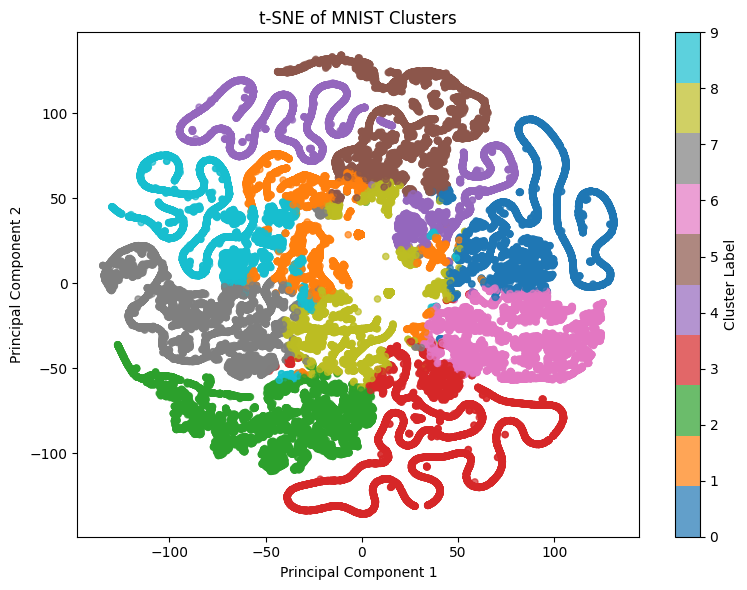

In [14]:
import matplotlib.pyplot as plt

# our clusters were recovered
plt.figure(figsize=(8, 6))
plt.scatter(
    components[:, 0],
    components[:, 1],
    c=labels,           
    cmap='tab10',
    s=20,
    alpha=0.7
)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('t-SNE of MNIST Clusters')
plt.colorbar(label='Cluster Label')
plt.tight_layout()
plt.show()

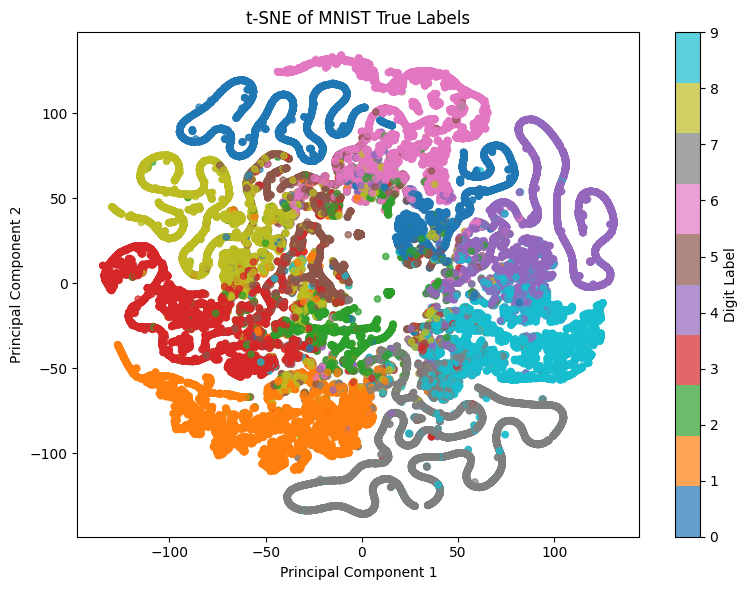

In [15]:
# Plot PCA colored by true digit labels
plt.figure(figsize=(8, 6))
plt.scatter(
    components[:, 0],
    components[:, 1],
    c=true_labels,
    cmap='tab10',
    s=20,
    alpha=0.7
)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('t-SNE of MNIST True Labels')
plt.colorbar(label='Digit Label')
plt.tight_layout()
plt.show()